In [1]:
import warnings
import math
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    RandomizedSearchCV,
)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import xgboost as xgb
import shap
from sklearn.inspection import PartialDependenceDisplay

R² log (CV médio) = 0.173, MAE log = 0.782, RMSE log = 0.982
R² linear (CV médio) = 0.004, MAE linear = 596.4, RMSE linear = 1099.5


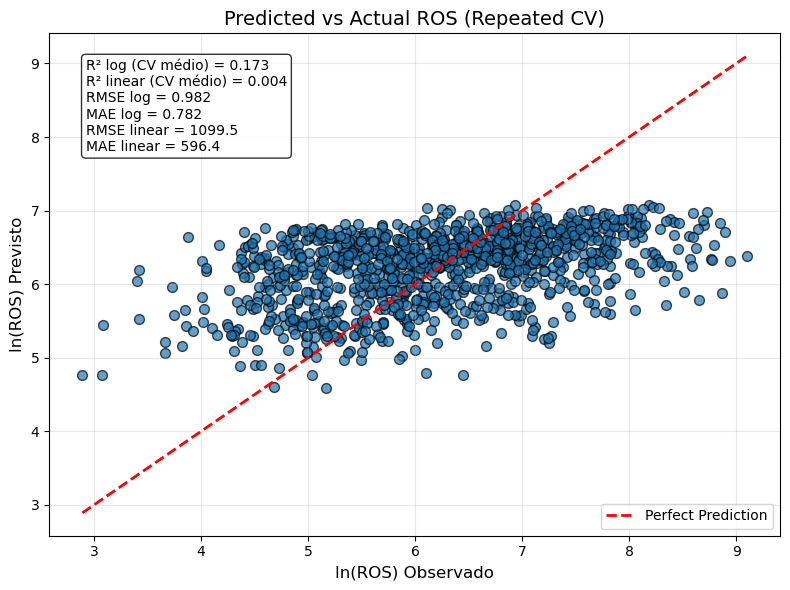


✅ Modelo salvo em 'model_benchmark_cv.pkl'


In [32]:
# ============================================================
# MODELO LOG-LINEAR ROS ~ wv10_log + dfmc + LFMC (CV médio)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------------------------------------
# 1. Selecionar variáveis
# ------------------------------------------------------------
X_model = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]]  # ajuste se nomes diferentes
y_model = y  # ln(ROS), já log-transformado

# ------------------------------------------------------------
# 2. Criar pipeline
# ------------------------------------------------------------
pipeline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Configuração RepeatedKFold
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# ------------------------------------------------------------
# 4. Repeated CV: acumular somas e contagens
# ------------------------------------------------------------
n_samples = len(X_model)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred = pipeline_model.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 5. Médias por observação
# ------------------------------------------------------------
y_pred_log = y_pred_sum / y_pred_count
y_actual_log = y_test_sum / y_test_count

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_pred_linear = inverse_safe_log(y_pred_log)
y_actual_linear = inverse_safe_log(y_actual_log)

# ------------------------------------------------------------
# 6. Métricas por fold (R² médio)
# ------------------------------------------------------------
r2_folds_log = []
r2_folds_linear = []

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred_fold = pipeline_model.fit(X_train, y_train).predict(X_test)

    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    r2_folds_linear.append(r2_score(inverse_safe_log(y_test), inverse_safe_log(y_pred_fold)))

r2_log_cv = np.mean(r2_folds_log)
r2_linear_cv = np.mean(r2_folds_linear)

# Outras métricas
mae_log = mean_absolute_error(y_actual_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_actual_log, y_pred_log))
mae_linear = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

print(f"R² log (CV médio) = {r2_log_cv:.3f}, MAE log = {mae_log:.3f}, RMSE log = {rmse_log:.3f}")
print(f"R² linear (CV médio) = {r2_linear_cv:.3f}, MAE linear = {mae_linear:.1f}, RMSE linear = {rmse_linear:.1f}")

# ------------------------------------------------------------
# 7. Scatter plot Predicted vs Actual
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_actual_log, y_pred_log, alpha=0.7, edgecolor='k', s=50)
min_val = min(y_actual_log.min(), y_pred_log.min())
max_val = max(y_actual_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title("Predicted vs Actual ROS (Repeated CV)", fontsize=14)
plt.xlabel("ln(ROS) Observado", fontsize=12)
plt.ylabel("ln(ROS) Previsto", fontsize=12)
plt.text(
    0.05, 0.95,
    f'R² log (CV médio) = {r2_log_cv:.3f}\n'
    f'R² linear (CV médio) = {r2_linear_cv:.3f}\n'
    f'RMSE log = {rmse_log:.3f}\n'
    f'MAE log = {mae_log:.3f}\n'
    f'RMSE linear = {rmse_linear:.1f}\n'
    f'MAE linear = {mae_linear:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. Salvar modelo
# ------------------------------------------------------------
with open(r"..\..\Data\Models\model_benchmark_cv.pkl", "wb") as f:
    pickle.dump(pipeline_model, f)

print("\n✅ Modelo salvo em 'model_benchmark_cv.pkl'")


In [33]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (log-linear ROS)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Selecionar variáveis e target
# ------------------------------------------------------------
X_shap = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]].copy()
y_shap = y.copy()  # ln(ROS)
final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Repeated CV: acumular somas e contagens
# ------------------------------------------------------------
n_samples = len(X_shap)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

print("🔄 Calculando PredROS médias com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    y_pred_test = pipeline.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred_test
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 4. Médias por observação
# ------------------------------------------------------------
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

avg_pred_linear = inverse_safe_log(avg_pred_log)
avg_actual_linear = inverse_safe_log(avg_actual_log)

# DataFrame de resultados
shap_results = pd.DataFrame(index=X_shap.index)
shap_results['PredROS_log'] = avg_pred_log
shap_results['ros_p_log'] = avg_actual_log
shap_results['PredROS_linear'] = avg_pred_linear
shap_results['ros_p_linear'] = avg_actual_linear
shap_results['PredDiff'] = avg_pred_linear - avg_pred_linear.mean()
shap_results['Err_pct'] = ((avg_pred_linear - avg_actual_linear) / avg_actual_linear) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > 35  # threshold

# ------------------------------------------------------------
# 5. Métricas médias por fold (R² médio)
# ------------------------------------------------------------
r2_folds_log = []
r2_folds_linear = []

for train_idx, test_idx in rkf.split(X_shap):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    y_pred_fold = pipeline.fit(X_train, y_train).predict(X_test)

    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    r2_folds_linear.append(r2_score(inverse_safe_log(y_test), inverse_safe_log(y_pred_fold)))

r2_log_cv = np.mean(r2_folds_log)
r2_linear_cv = np.mean(r2_folds_linear)

mae_log = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))
mae_linear = mean_absolute_error(avg_actual_linear, avg_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(avg_actual_linear, avg_pred_linear))

print(f"R² log (CV médio) = {r2_log_cv:.3f}, MAE log = {mae_log:.3f}, RMSE log = {rmse_log:.3f}")
print(f"R² linear (CV médio) = {r2_linear_cv:.3f}, MAE linear = {mae_linear:.1f}, RMSE linear = {rmse_linear:.1f}")

# ------------------------------------------------------------
# 6. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features...")
explainer = shap.LinearExplainer(pipeline.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# 7. Merge com GeoDataFrame original
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)

shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True).add_prefix('shap_')

merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 8. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS médias com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 261.76it/s]


R² log (CV médio) = 0.173, MAE log = 0.782, RMSE log = 0.982
R² linear (CV médio) = 0.004, MAE linear = 596.4, RMSE linear = 1099.5
🔹 Calculando SHAP values para todas as features...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv


R² log = 0.173 ± 0.077, MAE log = 0.782 ± 0.049, RMSE log = 0.981 ± 0.052
R² linear = 0.004 ± 0.052, MAE linear = 596.6 ± 90.4, RMSE linear = 1078.6 ± 214.2


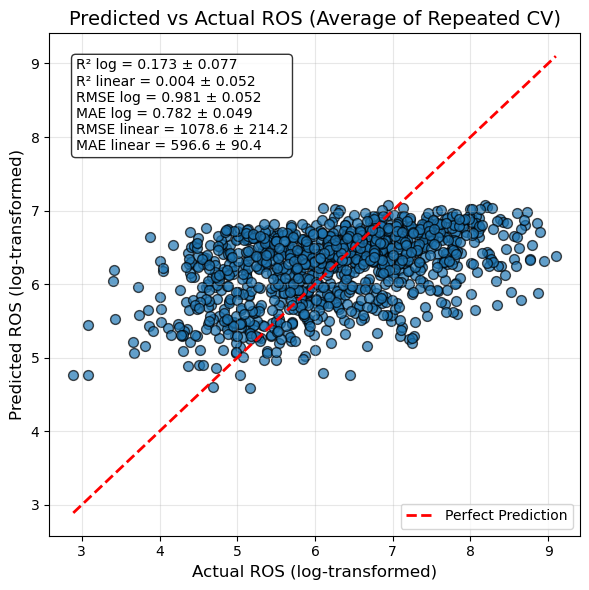

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RepeatedKFold

# ============================================================
# 1. Configurações de CV
# ============================================================
n_splits = 10
n_repeats = 5
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# ============================================================
# 2. Acumular somas e contagens para médias (Repeated CV)
# ============================================================
n_samples = len(X_model)
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred = pipeline_model.fit(X_train, y_train).predict(X_test)

    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

# ============================================================
# 3. Médias por observação
# ============================================================
y_pred_log_avg = y_pred_sum / y_pred_count
y_actual_log_avg = y_test_sum / y_test_count

# Função para reverter log
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_pred_linear_avg = inverse_safe_log(y_pred_log_avg)
y_actual_linear_avg = inverse_safe_log(y_actual_log_avg)

# ============================================================
# 4. Métricas médias por fold com std
# ============================================================
r2_folds_log = []
rmse_folds_log = []
mae_folds_log = []
r2_folds_linear = []
rmse_folds_linear = []
mae_folds_linear = []

for train_idx, test_idx in rkf.split(X_model):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y_model.iloc[train_idx], y_model.iloc[test_idx]

    y_pred_fold = pipeline_model.fit(X_train, y_train).predict(X_test)
    y_test_linear_fold = inverse_safe_log(y_test)
    y_pred_linear_fold = inverse_safe_log(y_pred_fold)

    # Log metrics
    r2_folds_log.append(r2_score(y_test, y_pred_fold))
    mae_folds_log.append(mean_absolute_error(y_test, y_pred_fold))
    rmse_folds_log.append(np.sqrt(mean_squared_error(y_test, y_pred_fold)))

    # Linear metrics
    r2_folds_linear.append(r2_score(y_test_linear_fold, y_pred_linear_fold))
    mae_folds_linear.append(mean_absolute_error(y_test_linear_fold, y_pred_linear_fold))
    rmse_folds_linear.append(np.sqrt(mean_squared_error(y_test_linear_fold, y_pred_linear_fold)))

# Média ± std
r2_log_mean, r2_log_std = np.mean(r2_folds_log), np.std(r2_folds_log)
r2_linear_mean, r2_linear_std = np.mean(r2_folds_linear), np.std(r2_folds_linear)
mae_log_mean, mae_log_std = np.mean(mae_folds_log), np.std(mae_folds_log)
rmse_log_mean, rmse_log_std = np.mean(rmse_folds_log), np.std(rmse_folds_log)
mae_linear_mean, mae_linear_std = np.mean(mae_folds_linear), np.std(mae_folds_linear)
rmse_linear_mean, rmse_linear_std = np.mean(rmse_folds_linear), np.std(rmse_folds_linear)

print(f"R² log = {r2_log_mean:.3f} ± {r2_log_std:.3f}, MAE log = {mae_log_mean:.3f} ± {mae_log_std:.3f}, RMSE log = {rmse_log_mean:.3f} ± {rmse_log_std:.3f}")
print(f"R² linear = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}, MAE linear = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}, RMSE linear = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}")

# ============================================================
# 5. Scatter plot Predicted vs Actual com ± std
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_actual_log_avg, y_pred_log_avg, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_log_avg.min(), y_pred_log_avg.min())
max_val = max(y_actual_log_avg.max(), y_pred_log_avg.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Average of Repeated CV)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² log = {r2_log_mean:.3f} ± {r2_log_std:.3f}\n'
    f'R² linear = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}\n'
    f'RMSE log = {rmse_log_mean:.3f} ± {rmse_log_std:.3f}\n'
    f'MAE log = {mae_log_mean:.3f} ± {mae_log_std:.3f}\n'
    f'RMSE linear = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}\n'
    f'MAE linear = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


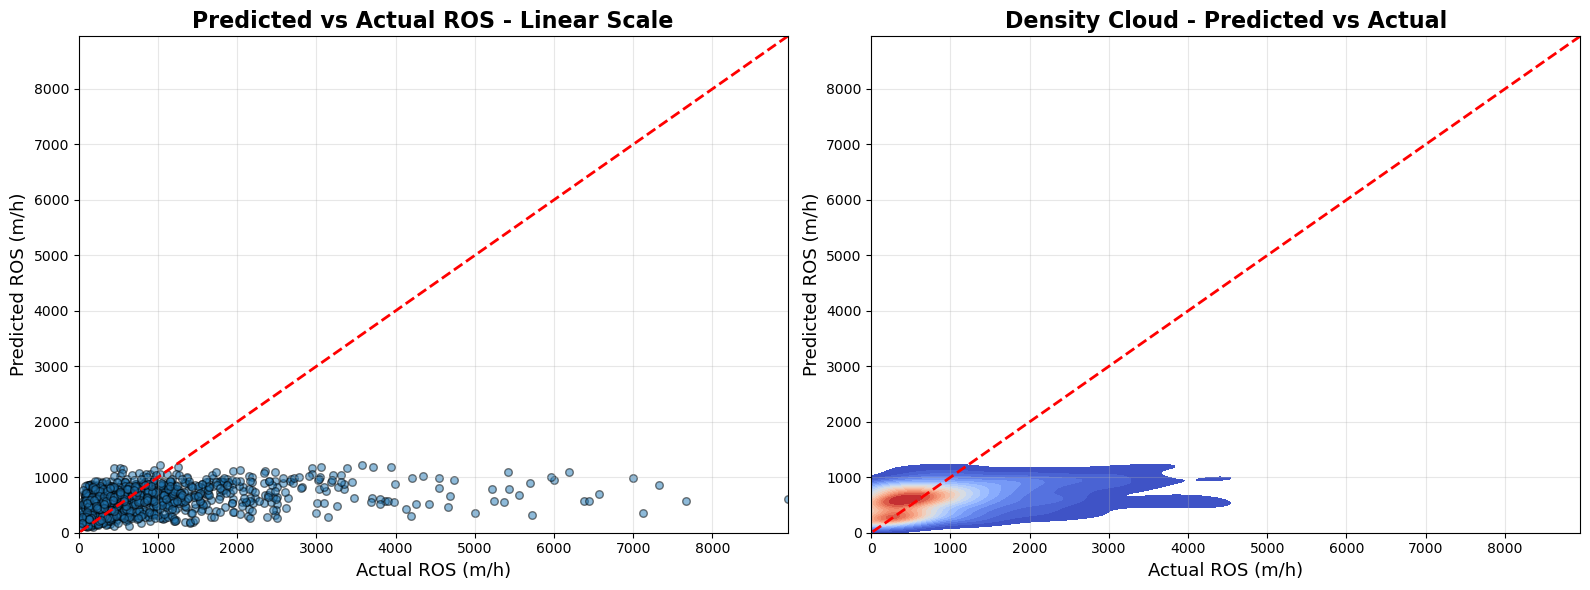

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(y_model.values)
y_pred_linear = inverse_safe_log(pipeline_model.predict(X_model))

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


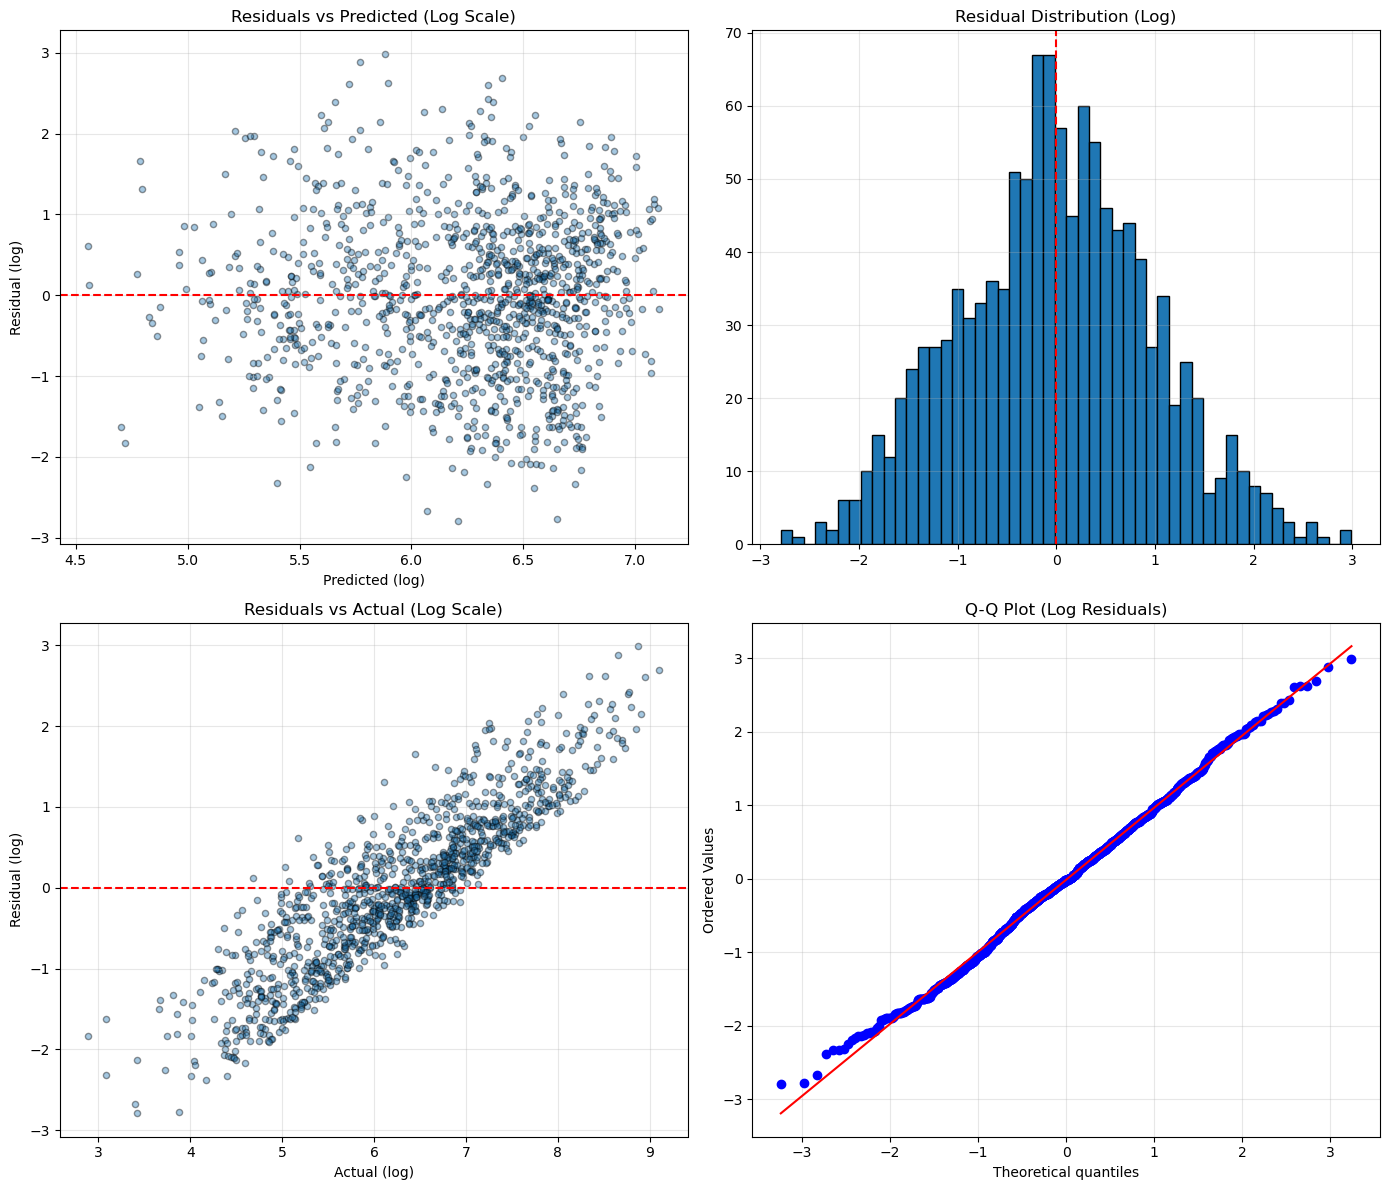

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = y_model.values
avg_pred   = pipeline_model.predict(X_model)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


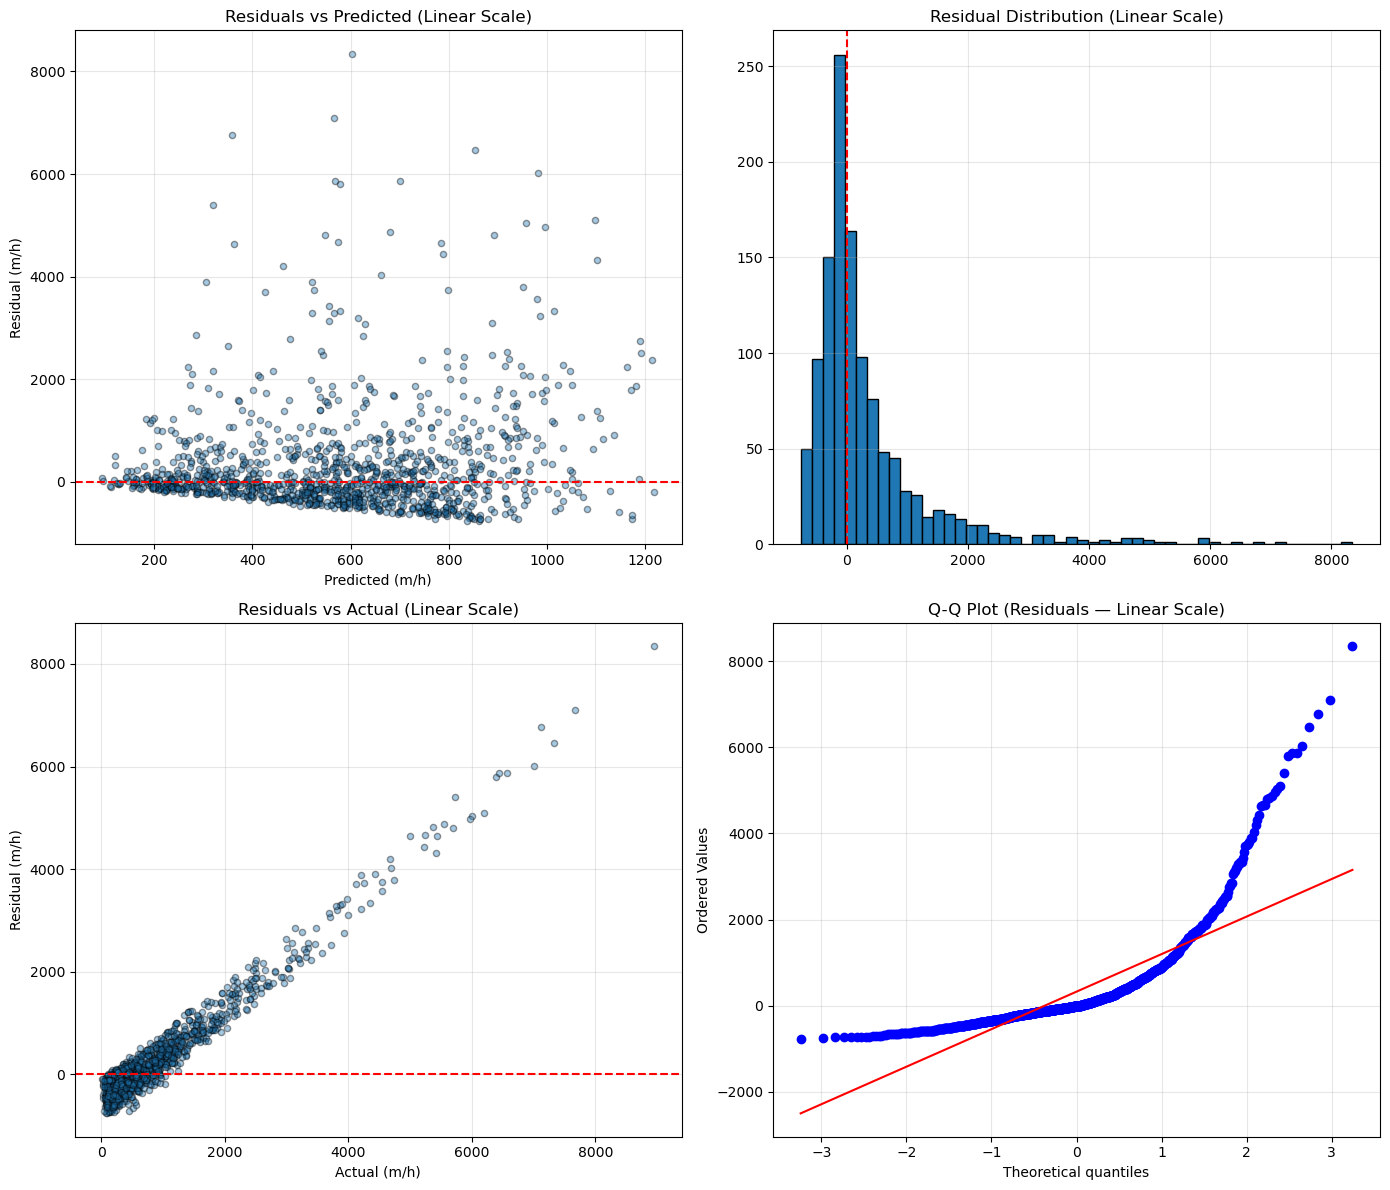

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 364  (31.0%)
Bad Predictions  : 809  (69.0%)


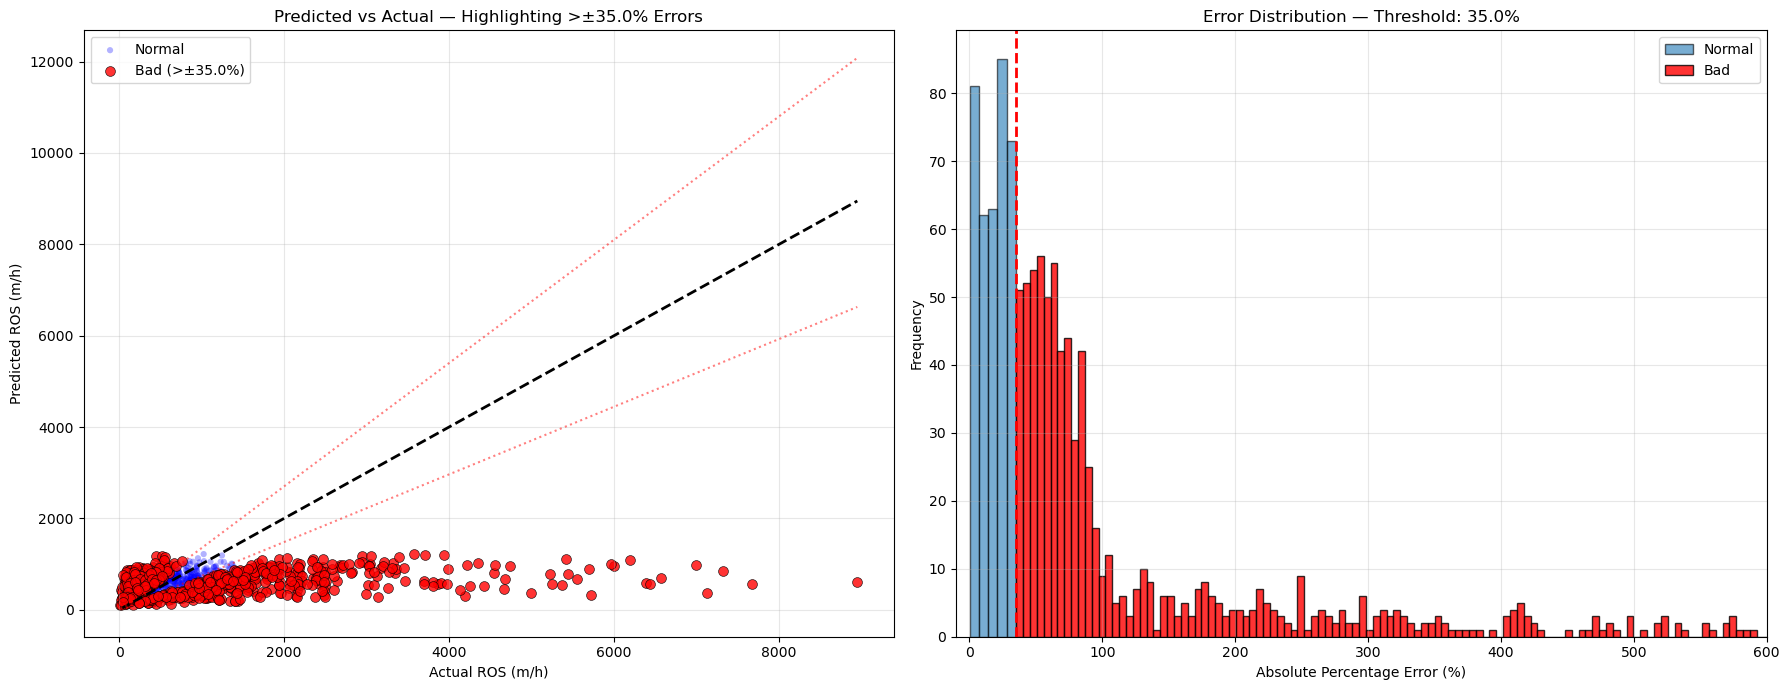

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Usar previsões do modelo final
# =============================
avg_actual_log = y_model.values
avg_pred_log   = pipeline_model.predict(X_model)

# Converter para escala linear
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()
